<a href="https://colab.research.google.com/github/lnsayer/personal_repo/blob/main/drug%20discovery%20with%20BACE%20dataset/graph_classification_bace_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit
!pip install torch_geometric
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.7 MB/s eta 0:00:00


In [38]:
import requests
from pathlib import Path
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from torch_geometric.data import InMemoryDataset
import deepchem as dc
import torch
import tqdm

In [3]:
data_path = Path("data/")
bace_path = data_path / "bace"

In [4]:
print(type(bace_path))

<class 'pathlib.PosixPath'>


In [5]:
if bace_path.is_dir():
  print(f"{bace_path} is already a directory")
else:
  print(f"{bace_path} is not a directory, creating one")
  bace_path.mkdir(parents=True, exist_ok=True)

  with open(bace_path / "bace.csv", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/lnsayer/personal_repo/main/drug%20discovery%20with%20BACE%20dataset/data/bace.csv")
    print("Downloading data")
    f.write(request.content)

data/bace is not a directory, creating one


In [6]:
bace_df = pd.read_csv(bace_path/ "bace.csv")
bace_df

,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,53.205711,78.640335,226.855410,107.434910,37.133846,0.000000,7.980170,0.000000,0.000000,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,73.817162,47.171600,365.676940,174.076750,34.923889,7.980170,24.148668,0.000000,24.663788,2
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,70.365707,47.941147,192.406520,255.752550,23.654478,0.230159,15.879790,0.000000,24.663788,3
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,56.657166,37.954151,194.353040,202.763350,36.498634,0.980913,8.188327,0.000000,26.385181,4
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,78.945702,39.361153,179.712880,220.461300,23.654478,0.230159,15.879790,0.000000,26.100143,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,BACE_1543,0,Test,3.000000,364.86969,2.5942,3,2,6,...,37.212799,37.681076,180.226410,95.670128,30.107586,9.368159,7.980170,0.000000,0.000000,1543
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,BACE_1544,0,Test,3.000000,357.83731,2.8229,3,2,6,...,45.792797,47.349350,122.401500,99.877144,30.107586,9.368159,7.980170,0.000000,0.000000,1544
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,BACE_1545,0,Test,2.953115,320.18451,3.0895,2,1,2,...,47.790600,22.563574,96.290794,58.798935,20.071724,9.368159,0.000000,6.904104,0.000000,1545
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,BACE_1546,0,Test,2.733298,317.38440,3.8595,2,1,3,...,77.219978,9.316234,95.907784,112.609720,20.071724,9.368159,0.000000,6.904104,0.000000,1546


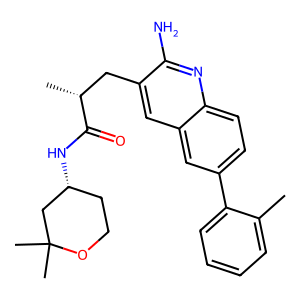

In [7]:
inhibitor = bace_df["mol"][0]

m = Chem.MolFromSmiles(inhibitor)

img = Draw.MolToImage(m)

display(img)

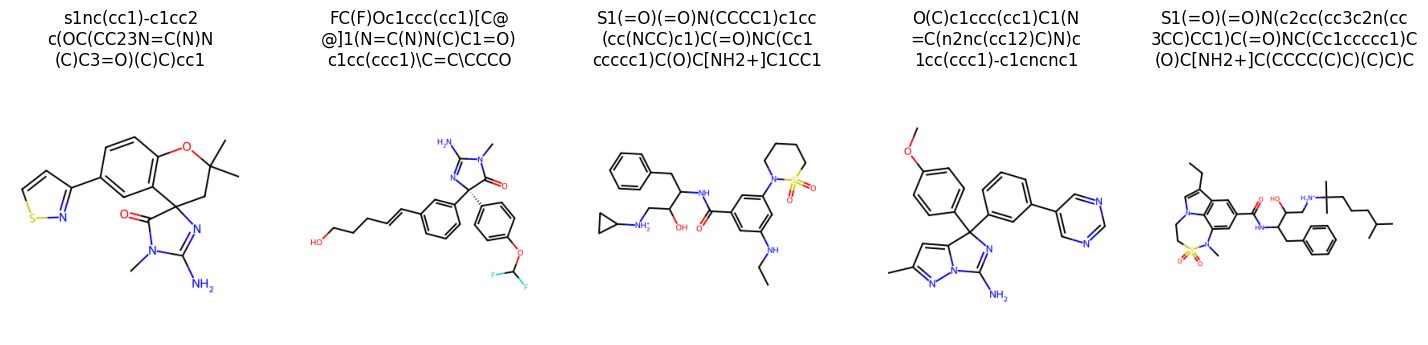

In [8]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize = (18,6))
mols = bace_df.sample(n=5, random_state=42)["mol"]

for i in range(len(mols)):

  mol = mols.iloc[i]
  m = Chem.MolFromSmiles(mol)
  img = Draw.MolToImage(m)

  ax[i].imshow(img)
  ax[i].axis(False);
  # ax[i].set_title(mol, wrap=True)

  first_part = mol[:int(len(mol)/3)]
  second_part = mol[int(len(mol)//3):int(2*len(mol)//3)]
  third_part = mol[int(2*len(mol)//3):]

  assert len(mol) == len(first_part)+len(second_part)+len(third_part)

  first_title = first_part + "\n"
  second_title = second_part + "\n"
  third_title = third_part + "\n"

  ax[i].set_title(first_title+second_title+third_title)

In [9]:
from deepchem.feat.graph_data import GraphData
from torch_geometric.data import Data

mol = bace_df["mol"][4]
m = Chem.MolFromSmiles(mol)


featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)


out = featurizer.featurize(datapoints=mol)

type(out[0])

pyg_out = GraphData.to_pyg_graph(out[0])
print(pyg_out)

data = Data(x=pyg_out.x, edge_index=pyg_out.edge_index,
            edge_attr=pyg_out.edge_attr,
            dtype=torch.float)


Data(x=[44, 30], edge_index=[2, 96], edge_attr=[96, 11])


In [39]:
class BaceDataset(InMemoryDataset):
  def __init__(self, root, csv_file, transform=None,
               pre_transform=None, pre_filter=None):
    self.csv_file = csv_file
    super().__init__(root, transform, pre_transform,
                     pre_filter)
    # self.data, self.slices = torch.load(self.processed_paths[0])

  @property
  def raw_file_names(self):
    return self.csv_file

  @property
  def processed_file_names(self):
    return ['data.pt']

  def download(self):
    # No need to download as data is already provided in a CSV
    pass

  def process(self):
    self.data = pd.read_csv(self.raw_paths[0]).reser_index()

    featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

    data_list = []
    for idx, row in tqdm(self.data.iterrows()):
      smiles = row['mol']
      label = row['Class']

      out = featurizer.featurize(smiles)
      pyg_out = GraphData.to_pyg_graph(out[0])

      data = Data(x=pyg_out.x, edge_index=pyg_out.edge_index, edge_attr=pyg_out.edge_attr,
                  y=torch.tensor([label]), dtype = torch.float)
      data_list.append(data)
    if self.pre_filter is not None:
          data_list = [data for data in data_list if self.pre_filter(data)]

    if self.pre_transform is not None:
          data_list = [self.pre_transform(data) for data in data_list]

    self.save(data_list, self.processed_paths[0])


In [40]:
bace_csv = bace_path/ "bace.csv"
bace_dataset = data_path / "bace_dataset"
dataset = BaceDataset(root = bace_dataset, csv_file = bace_csv)

In [37]:
from torch_geometric.loader import DataLoader

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
print(dataloader)


TypeError: 'DataLoader' object is not subscriptable

In [ ]:
graph = next(iter(dataloader))

In [23]:
bace_df = pd.read_csv(bace_csv)

featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

data_list = []
for idx, row in bace_df.iterrows():
  smiles = row['mol']
  label = row['Class']

  out = featurizer.featurize(smiles)
  pyg_out = GraphData.to_pyg_graph(out[0])

  data = Data(x=pyg_out.x, edge_index=pyg_out.edge_index, edge_attr=pyg_out.edge_attr,
              y=torch.tensor([label]), dtype = torch.float)
  data_list.append(data)

In [28]:
data_list[3]

Data(x=[40, 30], edge_index=[2, 84], edge_attr=[84, 11], y=[1], dtype=torch.float32)